In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import re
import string
import urllib
import gzip
import time
import nltk
import gensim 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from collections import Counter

from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, Flatten, MaxPool1D, GlobalMaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Data Gathering

In [ ]:
real_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/real.csv")
real_news.head()

,Unnamed: 0,Unnamed: 0.1,id,title,publication,author,date,year,month,url,content
0,0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,8,8,17291,"First, a Mixtape. Then a Romance. - The New Yo...",New York Times,Katherine Rosman,2016-12-31,2016.0,12.0,NaN,"Just how is Hillary Kerr, the founder of ..."
2,9,9,17292,Calling on Angels While Enduring the Trials of...,New York Times,Andy Newman,2016-12-31,2016.0,12.0,NaN,Angels are everywhere in the Muñiz family’s ap...
3,2547,2547,20127,U.S. Plans to Step Up Military Campaign Agains...,New York Times,Michael S. Schmidt and Eric Schmitt,2016-12-21,2016.0,12.0,NaN,"ABU DHABI, United Arab Emirates — The Obama..."
4,2551,2551,20131,272 Slaves Were Sold to Save Georgetown. What ...,New York Times,Rachel L. Swarns,2016-12-15,2016.0,12.0,NaN,WASHINGTON — The human cargo was loaded on ...


In [ ]:
fake_news = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Getting Real about Fake News_Kaggle/fake.csv")
fake_news.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [ ]:
# essential columns
fake_news1 = fake_news[['title', 'text','language','site_url']]
fake_news1 = fake_news1[fake_news1.language == 'english']
fake_news1['title'].fillna(value="", inplace=True)

# drop null 'text' rows as there is no context of the article
fake_news1.dropna(axis=0, inplace=True, subset=['text'])

# data shuffling and resetting index to avoid bias
fake_news1 = fake_news1.sample(frac=1.0) 
fake_news1.reset_index(drop=True,inplace=True)
fake_news1.head()

,title,text,language,site_url
0,Man wildly optimistic ahead of flat pack assembly,"October 29, 2016 \nA man with no DIY experienc...",english,newsbiscuit.com
1,"His Fans Are Calling Trump Brave, But Here’s H...","By Jameson Parker News November 6, 2016 His Fa...",english,ifyouonlynews.com
2,Physicists Say Consciousness Should Be Conside...,advertisement - learn more It’s been more than...,english,collective-evolution.com
3,Shocking! Hillary Clinton Will Start World War 3,source Add To The Conversation Using Facebook ...,english,pakalertpress.com
4,Comment on Two hundred classmates (and their p...,"Posted on September 3, 2015 by DCG | 25 Commen...",english,fellowshipoftheminds.com


In [ ]:
#feature extraction
fake_news2 = fake_news1[['title', 'text','site_url']]

#data labelling
fake_news2['label'] = 'fake'
fake_news2.head()

,title,text,site_url,label
0,Man wildly optimistic ahead of flat pack assembly,"October 29, 2016 \nA man with no DIY experienc...",newsbiscuit.com,fake
1,"His Fans Are Calling Trump Brave, But Here’s H...","By Jameson Parker News November 6, 2016 His Fa...",ifyouonlynews.com,fake
2,Physicists Say Consciousness Should Be Conside...,advertisement - learn more It’s been more than...,collective-evolution.com,fake
3,Shocking! Hillary Clinton Will Start World War 3,source Add To The Conversation Using Facebook ...,pakalertpress.com,fake
4,Comment on Two hundred classmates (and their p...,"Posted on September 3, 2015 by DCG | 25 Commen...",fellowshipoftheminds.com,fake


In [ ]:
#all site_urls
site_urls = fake_news2['site_url']

#removing domain extensions
site_urls2 = [x.split('.',1)[0] for x in site_urls]

#replacing the old site_url column with these values
fake_news2['site_url'] = site_urls2
fake_news2.head()

,title,text,site_url,label
0,Man wildly optimistic ahead of flat pack assembly,"October 29, 2016 \nA man with no DIY experienc...",newsbiscuit,fake
1,"His Fans Are Calling Trump Brave, But Here’s H...","By Jameson Parker News November 6, 2016 His Fa...",ifyouonlynews,fake
2,Physicists Say Consciousness Should Be Conside...,advertisement - learn more It’s been more than...,collective-evolution,fake
3,Shocking! Hillary Clinton Will Start World War 3,source Add To The Conversation Using Facebook ...,pakalertpress,fake
4,Comment on Two hundred classmates (and their p...,"Posted on September 3, 2015 by DCG | 25 Commen...",fellowshipoftheminds,fake


In [ ]:
#feature extraction
real_news2 = real_news[['title', 'content', 'publication']]

#data labelling
real_news2['label'] = 'real'
real_news2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,title,content,publication,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


In [ ]:
#rename features in our final datasets
newlabels = ['title', 'content', 'publication', 'label']
real_news2.columns = newlabels
fake_news2.columns = newlabels

In [ ]:
fake_news2.head()

,title,content,publication,label
0,Man wildly optimistic ahead of flat pack assembly,"October 29, 2016 \nA man with no DIY experienc...",newsbiscuit,fake
1,"His Fans Are Calling Trump Brave, But Here’s H...","By Jameson Parker News November 6, 2016 His Fa...",ifyouonlynews,fake
2,Physicists Say Consciousness Should Be Conside...,advertisement - learn more It’s been more than...,collective-evolution,fake
3,Shocking! Hillary Clinton Will Start World War 3,source Add To The Conversation Using Facebook ...,pakalertpress,fake
4,Comment on Two hundred classmates (and their p...,"Posted on September 3, 2015 by DCG | 25 Commen...",fellowshipoftheminds,fake


In [ ]:
real_news2.head()

,title,content,publication,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,New York Times,real
1,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",New York Times,real
2,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,New York Times,real
3,U.S. Plans to Step Up Military Campaign Agains...,"ABU DHABI, United Arab Emirates — The Obama...",New York Times,real
4,272 Slaves Were Sold to Save Georgetown. What ...,WASHINGTON — The human cargo was loaded on ...,New York Times,real


#Data Concatenation

In [ ]:
#dataframe combined to form a new final Fake News Detection dataset
dataframes = [fake_news2, real_news2]
final_dataset = pd.concat(dataframes)

# Fill any null fields
final_dataset.title.fillna("", inplace=True)
final_dataset.content.fillna("", inplace=True)

final_dataset

,title,content,publication,label
0,Man wildly optimistic ahead of flat pack assembly,"October 29, 2016 \nA man with no DIY experienc...",newsbiscuit,fake
1,"His Fans Are Calling Trump Brave, But Here’s H...","By Jameson Parker News November 6, 2016 His Fa...",ifyouonlynews,fake
2,Physicists Say Consciousness Should Be Conside...,advertisement - learn more It’s been more than...,collective-evolution,fake
3,Shocking! Hillary Clinton Will Start World War 3,source Add To The Conversation Using Facebook ...,pakalertpress,fake
4,Comment on Two hundred classmates (and their p...,"Posted on September 3, 2015 by DCG | 25 Commen...",fellowshipoftheminds,fake
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,real
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,real
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,real
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,real


In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28069 entries, 0 to 15711
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        28069 non-null  object
 1   content      28069 non-null  object
 2   publication  28069 non-null  object
 3   label        28069 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


In [ ]:
final_dataset['label'] = final_dataset['label'].map({'real': 1, 'fake': 0})
final_dataset

,title,content,publication,label
0,Man wildly optimistic ahead of flat pack assembly,"October 29, 2016 \nA man with no DIY experienc...",newsbiscuit,0
1,"His Fans Are Calling Trump Brave, But Here’s H...","By Jameson Parker News November 6, 2016 His Fa...",ifyouonlynews,0
2,Physicists Say Consciousness Should Be Conside...,advertisement - learn more It’s been more than...,collective-evolution,0
3,Shocking! Hillary Clinton Will Start World War 3,source Add To The Conversation Using Facebook ...,pakalertpress,0
4,Comment on Two hundred classmates (and their p...,"Posted on September 3, 2015 by DCG | 25 Commen...",fellowshipoftheminds,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,Uber driver Keith Avila picked up a p...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Crews on Friday continued to search L...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,When the Obama administration announced a...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...",This story has been updated. A new law in...,Washington Post,1


In [ ]:
final_dataset['content'] = final_dataset['title'] + " " + final_dataset['content']
final_dataset

,title,content,publication,label
0,Man wildly optimistic ahead of flat pack assembly,Man wildly optimistic ahead of flat pack assem...,newsbiscuit,0
1,"His Fans Are Calling Trump Brave, But Here’s H...","His Fans Are Calling Trump Brave, But Here’s H...",ifyouonlynews,0
2,Physicists Say Consciousness Should Be Conside...,Physicists Say Consciousness Should Be Conside...,collective-evolution,0
3,Shocking! Hillary Clinton Will Start World War 3,Shocking! Hillary Clinton Will Start World War...,pakalertpress,0
4,Comment on Two hundred classmates (and their p...,Comment on Two hundred classmates (and their p...,fellowshipoftheminds,0
...,...,...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,An eavesdropping Uber driver saved his 16-year...,Washington Post,1
15708,Plane carrying six people returning from a Cav...,Plane carrying six people returning from a Cav...,Washington Post,1
15709,After helping a fraction of homeowners expecte...,After helping a fraction of homeowners expecte...,Washington Post,1
15710,"Yes, this is real: Michigan just banned bannin...","Yes, this is real: Michigan just banned bannin...",Washington Post,1


#Data Pre-Processing

In [ ]:
final_dataset = final_dataset[['content','label']]
final_dataset

,content,label
0,Man wildly optimistic ahead of flat pack assem...,0
1,"His Fans Are Calling Trump Brave, But Here’s H...",0
2,Physicists Say Consciousness Should Be Conside...,0
3,Shocking! Hillary Clinton Will Start World War...,0
4,Comment on Two hundred classmates (and their p...,0
...,...,...
15707,An eavesdropping Uber driver saved his 16-year...,1
15708,Plane carrying six people returning from a Cav...,1
15709,After helping a fraction of homeowners expecte...,1
15710,"Yes, this is real: Michigan just banned bannin...",1


Now remove extra characters

In [ ]:
def preprocess_text(df, remove_special=True):
    texts = df['content'].copy()
    labels = df['label'].copy()

    #Remove links 
    df["content"] = df["content"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["content"] = df["content"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["content"] = df["content"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["content"] = df["content"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
        
    #Strip Punctation
    df["content"] = df["content"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["content"] = df["content"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["content"] = df["content"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert content to lowercase
    df["content"] = df["content"].apply(lambda x: x.lower())
        
    #Remove multiple letter repeating words
    df["content"] = df["content"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["content"] = df["content"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["content"] = df["content"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))
    
    return df

#Preprocessing of entered Text
new_df = preprocess_text(final_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
#Remove posts with less than X words
min_words = 15
print("Before : Number of posts", len(new_df)) 
new_df["no. of. words"] = new_df["content"].apply(lambda x: len(re.findall(r'\w+', x)))
new_df = new_df[new_df["no. of. words"] >= min_words]

print("After : Number of posts", len(new_df))

Before : Number of posts 28069
After : Number of posts 27472


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#Vectorization - Word2Vec

gensim library

In [ ]:
## Dependent features
y=new_df['label'].values
# array is printed
y

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
## Independent Features
X = new_df.drop('label',axis=1)
X = [d.split() for d in new_df['content'].tolist()]

X[0]

['wildly',
 'optimistic',
 'ahead',
 'flat',
 'pack',
 'assembly',
 'october',
 'with',
 'experience',
 'aside',
 'around',
 'minutes',
 'assemble',
 'piece',
 'cabin',
 'this',
 'weekend',
 'eostokendot',
 'having',
 'glanced',
 'through',
 'page',
 'instruction',
 'booklet',
 'yearold',
 'nick',
 'ferguson',
 'plans',
 'start',
 'around',
 'saturday',
 'will',
 'definitely',
 'done',
 'quarter',
 'past',
 'slightly',
 'before',
 'eostokendot',
 'simultaneously',
 'making',
 'vegetarian',
 'chilli',
 'said',
 'eostokendot',
 'going',
 'complete',
 'both',
 'tasks',
 'cool',
 'that',
 'involves',
 'three',
 'young',
 'children',
 'eostokendot',
 'meanwhile',
 'ferguson',
 'hastily',
 'making',
 'plans',
 'take',
 'kids',
 'mothers',
 'eostokendot',
 'with',
 'nick',
 'what',
 'might',
 'call',
 'journey',
 'said',
 'eostokendot',
 'that',
 'begins',
 'relatively',
 'calmly',
 'progresses',
 'high',
 'strength',
 'alcohol',
 'ends',
 'with',
 'screaming',
 'rudyard',
 'kiplings',
 'into

In [ ]:
#array
print(type(y))
#list of list
print(type(X),type(X[0]))

<class 'numpy.ndarray'>
<class 'list'> <class 'list'>


Using Gensim Library

In [ ]:
#dimension - each word converted to a sequence of _DIM_ vectors
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, size=DIM, window=10, min_count=1)

In [ ]:
# Vocabulary size - unique words for which the vectors are created
len(w2v_model.wv.vocab)

159335

* The following vectors are going to be fed as INITIAL weight in the DL modeland THEN, 
* DL model will retrain these weights - to maximize accuracy. 
Better results as compared to directly inputting them in the model

In [ ]:
# print(w2v_model.wv['hiliary'])
# print(w2v_model.wv.most_similar['hiliary'])

##Tokenization

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [ ]:
X = tokenizer.texts_to_sequences(X)
# seq. no. is assigned for each word. Check is by running:
# tokenizer.word_index
X[0]

[6013,
 3644,
 739,
 4012,
 5021,
 3446,
 234,
 3,
 527,
 1962,
 110,
 595,
 11140,
 1066,
 9401,
 5,
 1266,
 1,
 291,
 21020,
 87,
 1120,
 8961,
 40573,
 2418,
 3866,
 5553,
 526,
 414,
 110,
 672,
 12,
 2092,
 314,
 1687,
 191,
 2246,
 63,
 1,
 4379,
 246,
 14312,
 33053,
 7,
 1,
 74,
 1200,
 103,
 6165,
 3057,
 2,
 3593,
 141,
 329,
 175,
 1,
 1109,
 5553,
 14068,
 246,
 526,
 93,
 705,
 2394,
 1,
 3,
 3866,
 18,
 118,
 273,
 2824,
 7,
 1,
 2,
 2401,
 1727,
 12531,
 18067,
 250,
 1968,
 3194,
 1984,
 3,
 5356,
 42865,
 48677,
 32,
 4334,
 110,
 1,
 1,
 1220,
 3,
 678,
 3532,
 349,
 860,
 1,
 3368,
 7105]

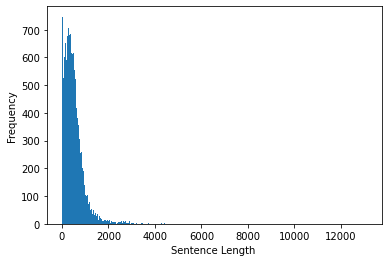

In [ ]:
plt.hist([len(i) for i in X] , bins = 700)
plt.xlabel('Sentence Length ',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.show()

In [ ]:
num = np.array([len(i) for i in X])
len(num[num>1500])

932

In [ ]:
#Remove posts with less than 1500 words
# Pad input sequences
max_words = 1500
X = pad_sequences(X, maxlen=max_words)

Not all word sequences will be generated by the gensim model. Some are unknown words can be present in the a new data, hence we add +1 for them.

In [ ]:
#Shape of article content tensor
X.shape

(27472, 1500)

In [ ]:
y.shape

(27472,)

In [ ]:
from keras.utils.np_utils import to_categorical
y = to_categorical(np.asarray(y),num_classes = 2)

In [ ]:
#Shape of label tensor
y.shape

(27472, 2)

#DL Model: CNN

Word Embedding

In [ ]:
### Vocabulary Size
voc_size = len(tokenizer.word_index) + 1
### Vocabulary 
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((voc_size, DIM)) #tuple

  for word,i in vocab.items():
    weight_matrix[i] = model.wv[word]
  
  return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape

(159336, 100)

In [ ]:
from keras.layers import Conv1D, MaxPooling1D

#Creating the Simple CNN model
sequence_input = Input(shape=(max_words,), dtype='int32')

embedding_layer = Embedding(voc_size, output_dim=DIM, weights=[embedding_vectors], input_length=max_words, trainable=False)(sequence_input)

#embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(128, 5, activation='relu')(embedding_layer)
l_pool1 = MaxPooling1D(5)(l_cov1)

l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)

l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
# global max pooling
l_pool3 = MaxPooling1D(35)(l_cov3) 

l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['acc'])

#print("Fitting the simple convolutional neural network model")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1500)]            0         
                                                                 
 embedding_5 (Embedding)     (None, 1500, 100)         15933600  
                                                                 
 conv1d_10 (Conv1D)          (None, 1496, 128)         64128     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 299, 128)         0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 295, 128)          82048     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 59, 128)          0         
 g1D)                                                      

#67-33 Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33, random_state=42)

As we are trying to use function decorator in TF 2.0, please enable run function eagerly by using below line after importing TensorFlow
By returning a Conv2D object tf.Variable(s) are created (weights, bias of conv layer) each time you call model() in your tf-decorated function. Hence, the exception.

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
history1 = model.fit(X_train1, y_train1, validation_data=(X_test1,y_test1), epochs=6, batch_size=128)

Epoch 1/6


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


144/144 [==============================] - 22s 154ms/step - loss: 0.7620 - acc: 0.4725 - val_loss: 0.6765 - val_acc: 0.5296
Epoch 2/6
144/144 [==============================] - 19s 132ms/step - loss: 0.6625 - acc: 0.5584 - val_loss: 0.6534 - val_acc: 0.5656
Epoch 3/6
144/144 [==============================] - 21s 149ms/step - loss: 0.6559 - acc: 0.5700 - val_loss: 0.6513 - val_acc: 0.5667
Epoch 4/6
144/144 [==============================] - 19s 133ms/step - loss: 0.6541 - acc: 0.5714 - val_loss: 0.6498 - val_acc: 0.5670
Epoch 5/6
144/144 [==============================] - 19s 132ms/step - loss: 0.6522 - acc: 0.5717 - val_loss: 0.6481 - val_acc: 0.5684
Epoch 6/6
144/144 [==============================] - 19s 133ms/step - loss: 0.6504 - acc: 0.5731 - val_loss: 0.6465 - val_acc: 0.5689


In [ ]:
y_pred1= (model.predict(X_test1) >= 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test1,y_pred1),2))

The Accuracy Score Is :  0.57


In [ ]:
confusion_matrix(y_test1.argmax(axis=1), y_pred1.argmax(axis=1))

array([[  35, 3883],
       [  25, 5123]])

In [ ]:
print(classification_report(y_test1.argmax(axis=1), y_pred1.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.58      0.01      0.02      3918
           1       0.57      1.00      0.72      5148

    accuracy                           0.57      9066
   macro avg       0.58      0.50      0.37      9066
weighted avg       0.58      0.57      0.42      9066



##Graphs

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


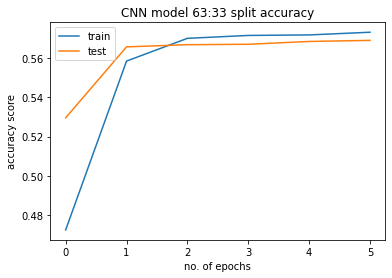

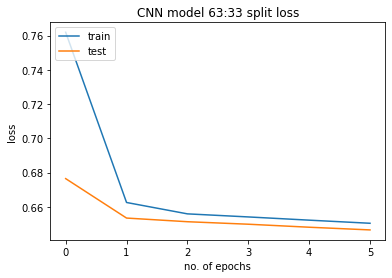

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('CNN model 63:33 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN model 63:33 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#70-30 Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
history2 = model.fit(X_train2,y_train2,validation_data=(X_test2,y_test2),epochs=6,batch_size=128)

Epoch 1/6
  1/151 [..............................] - ETA: 16s - loss: 0.6611 - acc: 0.5469

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


151/151 [==============================] - 20s 130ms/step - loss: 0.6490 - acc: 0.5963 - val_loss: 0.6442 - val_acc: 0.6130
Epoch 2/6
151/151 [==============================] - 20s 134ms/step - loss: 0.6473 - acc: 0.6053 - val_loss: 0.6428 - val_acc: 0.6133
Epoch 3/6
151/151 [==============================] - 20s 131ms/step - loss: 0.6458 - acc: 0.6054 - val_loss: 0.6420 - val_acc: 0.6143
Epoch 4/6
151/151 [==============================] - 20s 133ms/step - loss: 0.6443 - acc: 0.6062 - val_loss: 0.6405 - val_acc: 0.6142
Epoch 5/6
151/151 [==============================] - 20s 131ms/step - loss: 0.6431 - acc: 0.6063 - val_loss: 0.6394 - val_acc: 0.6139
Epoch 6/6
151/151 [==============================] - 20s 130ms/step - loss: 0.6418 - acc: 0.6066 - val_loss: 0.6391 - val_acc: 0.6151


In [ ]:
y_pred2= (model.predict(X_test2) >= 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
confusion_matrix(y_test2.argmax(axis=1), y_pred2.argmax(axis=1))

array([[2695,  843],
       [2329, 2375]])

In [ ]:
#accuracy_score(y_test,y_pred)
print('The Accuracy Score Is : ',round(accuracy_score(y_test2,y_pred2),2))

The Accuracy Score Is :  0.62


In [ ]:
print(classification_report(y_test2.argmax(axis=1), y_pred2.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.76      0.63      3538
           1       0.74      0.50      0.60      4704

    accuracy                           0.62      8242
   macro avg       0.64      0.63      0.61      8242
weighted avg       0.65      0.62      0.61      8242



In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline 
# # list all data in history
# print(history2.history2.keys())
# # summarize history for accuracy
# plt.plot(history2.history2['acc'])
# plt.plot(history2.history2['val_acc'])
# plt.title('CNN model 70:30 split accuracy')
# plt.ylabel('accuracy score')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history2.history2['loss'])
# plt.plot(history2.history2['val_loss'])
# plt.title('CNN model 70:30 split loss')
# plt.ylabel('loss')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#80-20 Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
history3 = model.fit(X_train3,y_train3,validation_data=(X_test3,y_test3),epochs=6,batch_size=128)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/6
172/172 [==============================] - 21s 123ms/step - loss: 0.6405 - acc: 0.6082 - val_loss: 0.6365 - val_acc: 0.6166
Epoch 2/6
172/172 [==============================] - 22s 128ms/step - loss: 0.6391 - acc: 0.6088 - val_loss: 0.6353 - val_acc: 0.6167
Epoch 3/6
172/172 [==============================] - 21s 123ms/step - loss: 0.6377 - acc: 0.6097 - val_loss: 0.6342 - val_acc: 0.6167
Epoch 4/6
172/172 [==============================] - 22s 128ms/step - loss: 0.6363 - acc: 0.6102 - val_loss: 0.6336 - val_acc: 0.6169
Epoch 5/6
172/172 [==============================] - 22s 128ms/step - loss: 0.6351 - acc: 0.6108 - val_loss: 0.6327 - val_acc: 0.6178
Epoch 6/6
172/172 [==============================] - 21s 124ms/step - loss: 0.6338 - acc: 0.6118 - val_loss: 0.6315 - val_acc: 0.6180


In [ ]:
y_pred3= (model.predict(X_test3) >= 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
confusion_matrix(y_test3.argmax(axis=1), y_pred3.argmax(axis=1))

array([[1803,  553],
       [1546, 1593]])

In [ ]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test3,y_pred3),2))

The Accuracy Score Is :  0.62


In [ ]:
print(classification_report(y_test3.argmax(axis=1), y_pred3.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.77      0.63      2356
           1       0.74      0.51      0.60      3139

    accuracy                           0.62      5495
   macro avg       0.64      0.64      0.62      5495
weighted avg       0.65      0.62      0.62      5495



In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline 
# # list all data in history
# print(history3.history3.keys())
# # summarize history for accuracy
# plt.plot(history3.history3['acc'])
# plt.plot(history3.history3['val_acc'])
# plt.title('CNN model 80:20 split accuracy')
# plt.ylabel('accuracy score')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history3.history3['loss'])
# plt.plot(history3.history3['val_loss'])
# plt.title('CNN model 80:20 split loss')
# plt.ylabel('loss')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#50-50 split

In [ ]:
from sklearn.model_selection import train_test_split
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
history4 = model.fit(X_train,y_train,validation_data=(X_test4,y_test4),epochs=6,batch_size=128)

Epoch 1/6
 1/65 [..............................] - ETA: 6s - loss: 0.6367 - acc: 0.5781

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


65/65 [==============================] - 12s 193ms/step - loss: 0.6311 - acc: 0.6088 - val_loss: 0.6328 - val_acc: 0.6174
Epoch 2/6
65/65 [==============================] - 11s 178ms/step - loss: 0.6303 - acc: 0.6095 - val_loss: 0.6324 - val_acc: 0.6169
Epoch 3/6
65/65 [==============================] - 11s 177ms/step - loss: 0.6295 - acc: 0.6093 - val_loss: 0.6322 - val_acc: 0.6177
Epoch 4/6
65/65 [==============================] - 13s 194ms/step - loss: 0.6288 - acc: 0.6116 - val_loss: 0.6318 - val_acc: 0.6171
Epoch 5/6
65/65 [==============================] - 11s 177ms/step - loss: 0.6281 - acc: 0.6115 - val_loss: 0.6315 - val_acc: 0.6178
Epoch 6/6
65/65 [==============================] - 11s 178ms/step - loss: 0.6274 - acc: 0.6122 - val_loss: 0.6312 - val_acc: 0.6183


In [ ]:
y_pred4= (model.predict(X_test4) > 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
confusion_matrix(y_test4.argmax(axis=1), y_pred4.argmax(axis=1))

array([[4560, 1364],
       [3879, 3933]])

In [ ]:
#accuracy_score(y_test,y_pred)
print('The Accuracy Score Is : ',round(accuracy_score(y_test4,y_pred4),2))

The Accuracy Score Is :  0.62


In [ ]:
print(classification_report(y_test4.argmax(axis=1), y_pred4.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.77      0.63      5924
           1       0.74      0.50      0.60      7812

    accuracy                           0.62     13736
   macro avg       0.64      0.64      0.62     13736
weighted avg       0.66      0.62      0.62     13736



In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline 
# # list all data in history
# print(history4.history4.keys())
# # summarize history for accuracy
# plt.plot(history4.history4['acc'])
# plt.plot(history4.history4['val_acc'])
# plt.title('CNN model 50:50 split accuracy')
# plt.ylabel('accuracy score')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history4.history4['loss'])
# plt.plot(history4.history4['val_loss'])
# plt.title('CNN model 50:50 split loss')
# plt.ylabel('loss')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#30-70 Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.7, random_state=42)

In [ ]:
history5 = model.fit(X_train5,y_train5,validation_data=(X_test5,y_test5),epochs=6,batch_size=128)

Epoch 1/6
 1/65 [..............................] - ETA: 6s - loss: 0.6365 - acc: 0.5547

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


65/65 [==============================] - 18s 274ms/step - loss: 0.6266 - acc: 0.6117 - val_loss: 0.6312 - val_acc: 0.6178
Epoch 2/6
65/65 [==============================] - 18s 273ms/step - loss: 0.6259 - acc: 0.6125 - val_loss: 0.6309 - val_acc: 0.6176
Epoch 3/6
65/65 [==============================] - 13s 201ms/step - loss: 0.6253 - acc: 0.6134 - val_loss: 0.6305 - val_acc: 0.6178
Epoch 4/6
65/65 [==============================] - 18s 274ms/step - loss: 0.6245 - acc: 0.6139 - val_loss: 0.6304 - val_acc: 0.6181
Epoch 5/6
65/65 [==============================] - 18s 274ms/step - loss: 0.6239 - acc: 0.6146 - val_loss: 0.6299 - val_acc: 0.6180
Epoch 6/6
65/65 [==============================] - 18s 273ms/step - loss: 0.6231 - acc: 0.6133 - val_loss: 0.6300 - val_acc: 0.6196


In [ ]:
y_pred5= (model.predict(X_test5) > 0.5).astype("int32")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
confusion_matrix(y_test5.argmax(axis=1), y_pred5.argmax(axis=1))

array([[6470, 1820],
       [5496, 5445]])

In [ ]:
print('The Accuracy Score Is : ',round(accuracy_score(y_test5,y_pred5),2))

The Accuracy Score Is :  0.62


In [ ]:
print(classification_report(y_test5.argmax(axis=1), y_pred5.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.78      0.64      8290
           1       0.75      0.50      0.60     10941

    accuracy                           0.62     19231
   macro avg       0.65      0.64      0.62     19231
weighted avg       0.66      0.62      0.62     19231



In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline 
# # list all data in history
# print(history5.history5.keys())
# # summarize history for accuracy
# plt.plot(history5.history5['acc'])
# plt.plot(history5.history5['val_acc'])
# plt.title('CNN model 30:70 split accuracy')
# plt.ylabel('accuracy score')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history5.history5['loss'])
# plt.plot(history5.history5['val_loss'])
# plt.title('CNN model 30:70 split loss')
# plt.ylabel('loss')
# plt.xlabel('no. of epochs')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

#Comparison

In [ ]:
score_1 = accuracy_score(y_test1,y_pred1)
score_2 = accuracy_score(y_test2,y_pred2)
score_3 = accuracy_score(y_test3,y_pred3)
score_4 = accuracy_score(y_test4,y_pred4)
score_5 = accuracy_score(y_test5,y_pred5)
results = pd.DataFrame([["80:20 split",format(score_3*100,".2f")],["70:30 split",format(score_2*100,".2f")], ["67:33 split",format(score_1*100,".2f")],
                       ["50:50 split",format(score_4*100,".2f")],["30:70 split",format(score_5*100,".2f")]], columns=["Train:Test Split","Accuracy (%)"])
results

,Train:Test Split,Accuracy (%)
0,80:20 split,61.80
1,70:30 split,61.51
2,67:33 split,56.89
3,50:50 split,61.83
4,30:70 split,61.96


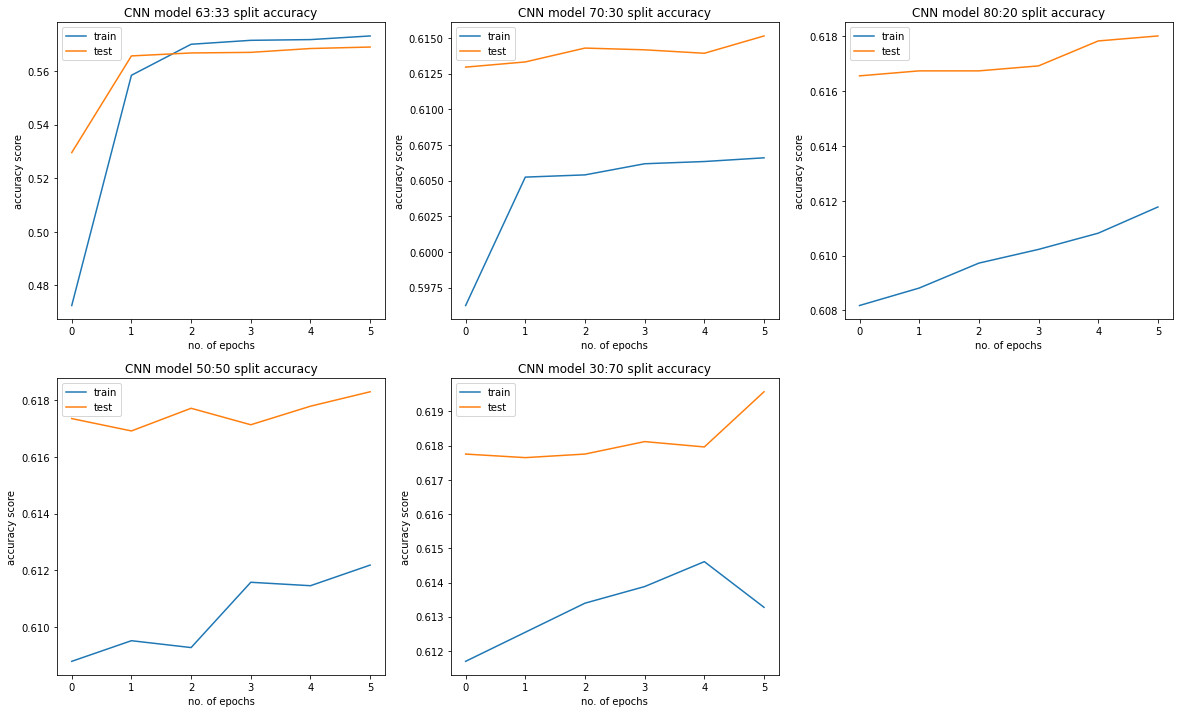

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('CNN model 63:33 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('CNN model 70:30 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('CNN model 80:20 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('CNN model 50:50 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('CNN model 30:70 split accuracy')
plt.ylabel('accuracy score')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

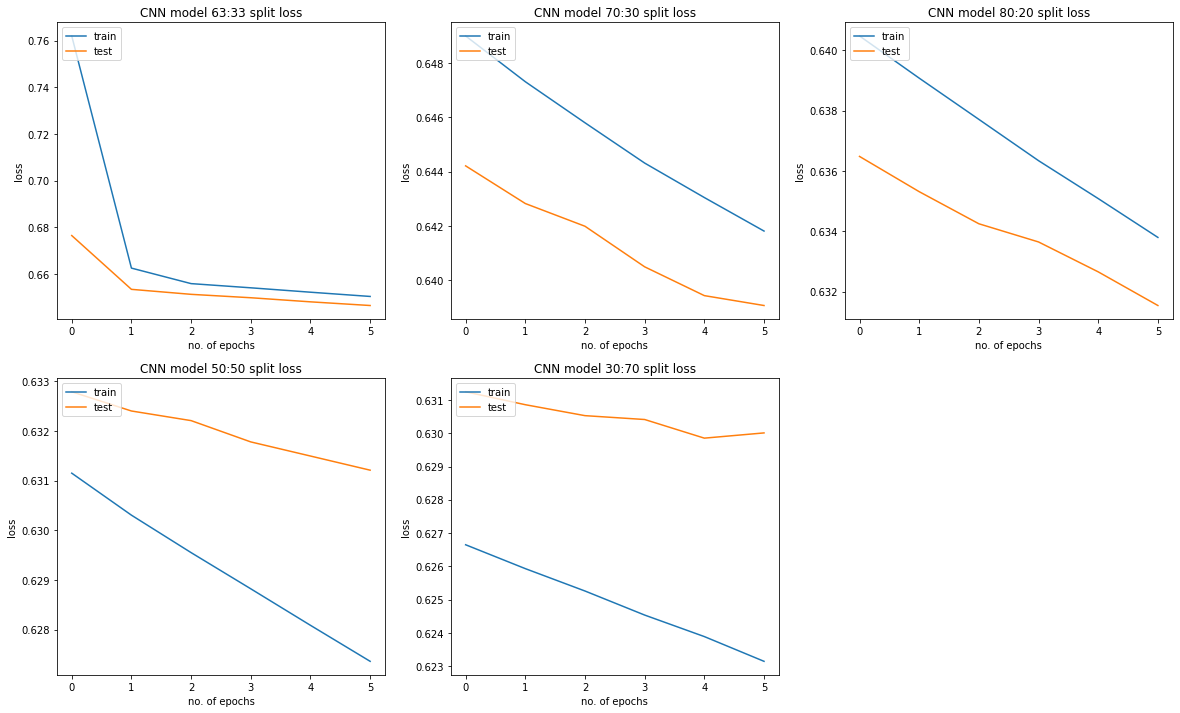

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN model 63:33 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('CNN model 70:30 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 3)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('CNN model 80:20 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 4)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('CNN model 50:50 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2, 3, 5)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('CNN model 30:70 split loss')
plt.ylabel('loss')
plt.xlabel('no. of epochs')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

#detection

Predictions on Testing Data ; https://www.kaggle.com/akarsh1/fakenews-classification-using-ml-and-deep-learning#Creating-Models 

Discussion: From the above results, it appears that LSTM Model gives the highest accuracy amongst various models. Therefore, it is selected as the final model for making predictions on final testing data.

In [ ]:
# # Making Predictions on test data
# predictions_test = pd.DataFrame(model.predict_classes(x_test_final))
# test_id = pd.DataFrame(test["id"])
# submission = pd.concat([test_id,predictions_test],axis=1)
# submission.columns = ["id","label"]
# submission.to_csv("Submission.csv",index=False)

AttributeError: ignored

In [ ]:
# submission.head()